In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Feb  9 15:00:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 32%   48C    P5              86W / 200W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 4096
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 38.0068359375
encoder.convs 5.9912109375
encoder.linear 32.015625
prior 0.0
latent 0.0
decoder 38.0286979675293
decoder.linear 32.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 38436
-rw-rw-r-- 1 scpark scpark   266142  2월  9 15:00 events.out.tfevents.1707457966.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 38669548  2월  9 14:53 save_0
-rw-rw-r-- 1 scpark scpark   416880  2월  9 14:52 events.out.tfevents.1707457106.scpark-X299-WU8


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/home/scpark/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

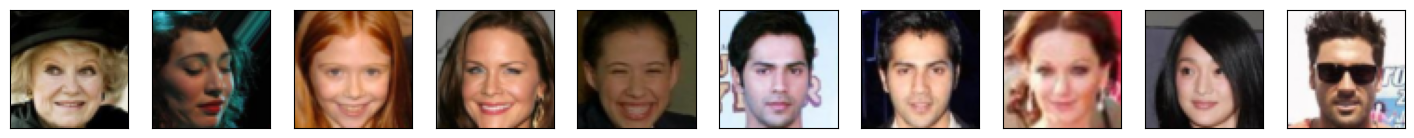

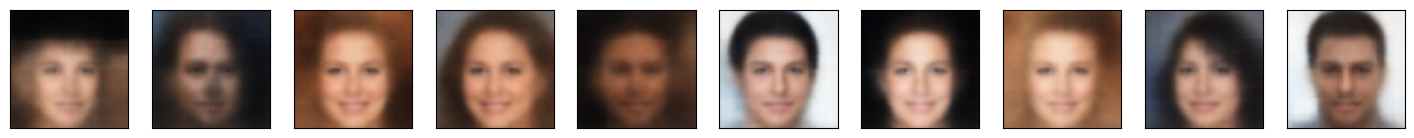

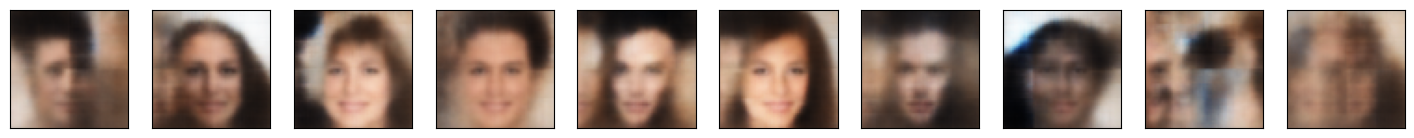

4001
swae_loss 0.08000189810991287
recon_loss 0.017792338505387306
4002
swae_loss 0.0822572410106659
recon_loss 0.017186399549245834
4003
swae_loss 0.07847252488136292
recon_loss 0.018134867772459984
4004
swae_loss 0.0636189803481102
recon_loss 0.017156049609184265
4005
swae_loss 0.08331077545881271
recon_loss 0.01817864179611206
4006
swae_loss 0.08727746456861496
recon_loss 0.017705075442790985
4007
swae_loss 0.07332021743059158
recon_loss 0.017284061759710312
4008
swae_loss 0.07805124670267105
recon_loss 0.01800946518778801
4009
swae_loss 0.08665876090526581
recon_loss 0.017459645867347717
4010
swae_loss 0.08581403642892838
recon_loss 0.01849619299173355
4011
swae_loss 0.08335721492767334
recon_loss 0.01775822788476944
4012
swae_loss 0.08613754063844681
recon_loss 0.01708786003291607
4013
swae_loss 0.08156824111938477
recon_loss 0.018830841407179832
4014
swae_loss 0.07900579273700714
recon_loss 0.017101462930440903
4015
swae_loss 0.0753132775425911
recon_loss 0.01794639602303505
4016

4125
swae_loss 0.08424155414104462
recon_loss 0.01699741743505001
4126
swae_loss 0.07538911700248718
recon_loss 0.017694061622023582
4127
swae_loss 0.08869853615760803
recon_loss 0.018310176208615303
4128
swae_loss 0.06808049231767654
recon_loss 0.0178359504789114
4129
swae_loss 0.08434467017650604
recon_loss 0.01803208701312542
4130
swae_loss 0.08820405602455139
recon_loss 0.017306149005889893
4131
swae_loss 0.07395463436841965
recon_loss 0.017464308068156242
4132
swae_loss 0.0763268917798996
recon_loss 0.017723366618156433
4133
swae_loss 0.07214652001857758
recon_loss 0.017527423799037933
4134
swae_loss 0.07779531925916672
recon_loss 0.01852179877460003
4135
swae_loss 0.08730701357126236
recon_loss 0.017416581511497498
4136
swae_loss 0.08393587917089462
recon_loss 0.017510082572698593
4137
swae_loss 0.07872629910707474
recon_loss 0.018423132598400116
4138
swae_loss 0.08120975643396378
recon_loss 0.017097866162657738
4139
swae_loss 0.08941011130809784
recon_loss 0.01657460816204548
41

4249
swae_loss 0.08590999245643616
recon_loss 0.017586521804332733
4250
swae_loss 0.08716706931591034
recon_loss 0.017707504332065582
4251
swae_loss 0.06889933347702026
recon_loss 0.018124064430594444
4252
swae_loss 0.08007480204105377
recon_loss 0.017529629170894623
4253
swae_loss 0.09135299175977707
recon_loss 0.01766648329794407
4254
swae_loss 0.08115442097187042
recon_loss 0.01744222640991211
4255
swae_loss 0.08605638146400452
recon_loss 0.01778566464781761
4256
swae_loss 0.07413702458143234
recon_loss 0.01858757995069027
4257
swae_loss 0.07105761021375656
recon_loss 0.018127497285604477
4258
swae_loss 0.08145217597484589
recon_loss 0.017669856548309326
4259
swae_loss 0.08998316526412964
recon_loss 0.017580188810825348
4260
swae_loss 0.09215617924928665
recon_loss 0.017275065183639526
4261
swae_loss 0.0705532655119896
recon_loss 0.017592890188097954
4262
swae_loss 0.06919720768928528
recon_loss 0.01858110912144184
4263
swae_loss 0.08019886165857315
recon_loss 0.01768728904426098
42

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        